In [1]:
import torch
from torch.utils.data import DataLoader, random_split, Dataset
import Models.Get_data as Gd
import numpy as np
import random
from Models.LSTM import LSTM_seq2seq
from torchinfo import summary
import pickle
import os
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
import os
from sklearn.decomposition import PCA

In [2]:
latent_space = 25
window_size = 10
step_size = 3
batch_size = 5

# 获取目录路径
dirpath = os.path.dirname(f'/home/wl4023/github repos/IRP/predict result/Latent space {latent_space}/a.txt')
# 创建目录（如果不存在）
os.makedirs(dirpath, exist_ok=True)

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(66)  # 你可以选择任意一个数字作为种子
# 启用浮点数异常检测
# torch.autograd.set_detect_anomaly(True)
directory = '/home/wl4023/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

In [4]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda:0


In [5]:
with open('/home/wl4023/github_repos/IRP/preprocessor.pkl', 'rb') as f:
    preprocessor = pickle.load(f)
print(preprocessor.mean, preprocessor.std)

6.95707893371582 9.811119079589844


In [6]:
class MyDataset(Dataset):
    def __init__(self, x, y, original_x, original_y):
        self.x = x
        self.y = y
        self.original_x = original_x
        self.original_y = original_y
    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.original_x[idx], self.original_y[idx]

In [7]:
dataset, length = Gd.get_all_nodes(folders[:-1])
dataset = dataset[:, :, 0]

pca = PCA(n_components=latent_space)
pca.fit(preprocessor.transform(dataset))

PCA(n_components=25)

In [8]:
pca_data = pca.transform(preprocessor.transform(dataset))
pca_data = torch.tensor(pca_data, dtype=torch.float32)
pca_data = Gd.segment_data_torch(pca_data, length, window_size, step_size)
print(pca_data.shape)

dataset = torch.tensor(dataset, dtype=torch.float32)

original_dataset = Gd.segment_data_torch(dataset, length, window_size, step_size)
original_dataset.shape

torch.Size([899, 10, 25])


torch.Size([899, 10, 97149])

In [9]:
data = MyDataset(pca_data[:, :5, :], pca_data[:, -5:, :], original_dataset[:, :5, :], original_dataset[:, -5:, :])
train_set, val_set = random_split(data, [0.8, 0.2])
train_loader = DataLoader(train_set, 10, True)
val_loader = DataLoader(val_set, 10)


In [10]:
len(train_set[0])

4

In [11]:
dataset_1, length = Gd.get_all_nodes(folders[-1:])
dataset_1 = dataset_1[:, :, 0]
test_pca_data = pca.transform(preprocessor.transform(dataset_1))
test_pca_data = torch.tensor(test_pca_data, dtype=torch.float32)
test_pca_data = Gd.segment_data_torch(test_pca_data, length, window_size, step_size)
print(test_pca_data.shape)


dataset_1 = torch.tensor(dataset_1, dtype=torch.float32)
test_origin_dataset = Gd.segment_data_torch(dataset_1, length, window_size, step_size)

test_data = MyDataset(test_pca_data[:, :5, :], test_pca_data[:, -5:, :], test_origin_dataset[:, :5, :], test_origin_dataset[:, -5:, :])
test_loader = DataLoader(test_data, 1)

torch.Size([31, 10, 25])


## train

In [12]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))
    
class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

In [13]:
def train(model, train_loader, val_loader, test_loader, criterion, metric, metric_test, optimizer, device=device, epochs=30, seq_len=5):
    train_NRMSELoss_list = []
    train_RMSELoss_list = []

    val_NRMSELoss_list = []
    val_RMSELoss_list = []

    test_NRMSELoss_list = []
    test_RMSELoss_list = []

    min_loss = 10000
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_metric = 0
        for x, y, _, original_y in tqdm(train_loader):
            input = x.to(device)
            label = y.to(device)
            optimizer.zero_grad()
            predict = model(input, seq_len)
            loss = criterion(predict, label)
            loss.backward()
            optimizer.step()
            recon_predict=[]
            for i in range(len(x)):
                temp = preprocessor.inverse_transform(pca.inverse_transform(predict[i].cpu().detach().numpy()))
                
                recon_predict.append(torch.tensor(temp, dtype=torch.float32))

            recon_predict = torch.stack(recon_predict, dim=0)
            # print(recon_predict)
            train_loss += criterion(original_y, recon_predict).item()
            train_metric += metric(original_y, recon_predict).item()
        
        train_loss /= len(train_loader)
        # print(train_loss, len(train_loader))
        train_metric /= len(train_loader)
        train_RMSELoss_list.append(train_loss)
        train_NRMSELoss_list.append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_metric = 0
            for x, y, _, original_y in val_loader:
                input = x.to(device)
                label = y.to(device)
                predict = model(input, seq_len)

                recon_predict=[]
                for i in range(len(x)):
                    temp = preprocessor.inverse_transform(pca.inverse_transform(predict[i].cpu().detach().numpy()))
                    recon_predict.append(torch.tensor(temp, dtype=torch.float32))

                recon_predict = torch.stack(recon_predict, dim=0)
                val_loss += criterion(original_y, recon_predict).item()
                val_metric += metric(original_y, recon_predict).item()
    
            val_loss /= len(val_loader)
            val_metric /= len(val_loader)
            val_RMSELoss_list.append(val_loss)
            val_NRMSELoss_list.append(val_metric)

        
        model.eval()
        with torch.no_grad():
            test_loss = 0
            test_metric = 0
            for x, y, _, original_y in test_loader:
                input = x.to(device)
                label = y.to(device)
                predict = model(input, seq_len)

                recon_predict=[]
                for i in range(len(x)):
                    temp = preprocessor.inverse_transform(pca.inverse_transform(predict[i].cpu().detach().numpy()))
                    recon_predict.append(torch.tensor(temp, dtype=torch.float32))

                recon_predict = torch.stack(recon_predict, dim=0)
                test_loss += criterion(original_y, recon_predict).item()
                test_metric += metric_test(original_y, recon_predict).item()
    
            test_loss /= len(test_loader)
            test_metric /= len(test_loader)
            test_RMSELoss_list.append(test_loss)
            test_NRMSELoss_list.append(test_metric)

        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {train_loss}, NRMSE_train_loss: {train_metric}, val Loss: {val_loss}, NRMSE_val_loss: {val_metric}, test Loss: {test_loss}, NRMSE_test_loss: {test_metric}')
        
        if min_loss >= val_metric:
            min_loss = val_metric
            torch.save(model.state_dict(), f'/home/wl4023/github_repos/IRP/predict result/Latent space {latent_space}/PCA_LSTM.pth')

    return train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list, test_RMSELoss_list, test_NRMSELoss_list

In [14]:
# Define the weights initialization function
def initialize_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

In [15]:
model = LSTM_seq2seq(latent_space, 100)
# model.apply(initialize_weights)
x = torch.rand((5, 5, latent_space))
summary(model, input_data=(x, 5))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM_seq2seq                             [5, 5, 25]                --
├─LSTM_encoder: 1-1                      [5, 100]                  --
│    └─LSTM_cell: 2-1                    [5, 100]                  50,400
│    └─LSTM_cell: 2-2                    [5, 100]                  (recursive)
│    └─LSTM_cell: 2-3                    [5, 100]                  (recursive)
│    └─LSTM_cell: 2-4                    [5, 100]                  (recursive)
│    └─LSTM_cell: 2-5                    [5, 100]                  (recursive)
├─LSTM_decoder: 1-2                      [5, 5, 25]                --
│    └─Linear: 2-6                       [5, 25]                   5,025
│    └─ELU: 2-7                          [5, 25]                   --
│    └─Linear: 2-8                       [5, 25]                   5,025
│    └─ELU: 2-9                          [5, 25]                   --
│    └─LSTM_cell: 2-10                 

In [16]:
model = model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = RMSELoss()
metric = NRMSE(dataset)
metric_test = NRMSE(dataset_1)
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list, test_RMSELoss_list, test_NRMSELoss_list = train(model,
                                                                                         train_loader,
                                                                                         val_loader,
                                                                                         test_loader,
                                                                                         criterion,
                                                                                         metric,
                                                                                         metric_test=metric_test,
                                                                                         optimizer=optimizer,
                                                                                         device=device,
                                                                                         epochs=50,
                                                                                         seq_len=5)

100%|██████████| 72/72 [00:01<00:00, 42.85it/s]


Epoch 1/50, train Loss: 8.87332938114802, NRMSE_train_loss: 0.17053458580954206, val Loss: 10.149711238013374, NRMSE_val_loss: 0.19506508939796025, test Loss: 4.229678446246732, NRMSE_test_loss: 0.24053088167021353


100%|██████████| 72/72 [00:01<00:00, 43.83it/s]


Epoch 2/50, train Loss: 8.868594156371223, NRMSE_train_loss: 0.17044358058936065, val Loss: 10.136364724900988, NRMSE_val_loss: 0.19480858825974995, test Loss: 4.216643610308247, NRMSE_test_loss: 0.23978962292594294


100%|██████████| 72/72 [00:01<00:00, 46.13it/s]


Epoch 3/50, train Loss: 8.804093460241953, NRMSE_train_loss: 0.16920395588709247, val Loss: 10.129504018359714, NRMSE_val_loss: 0.1946767336792416, test Loss: 4.213666339074412, NRMSE_test_loss: 0.23962031352904536


100%|██████████| 72/72 [00:01<00:00, 43.04it/s]


Epoch 4/50, train Loss: 8.847784605291155, NRMSE_train_loss: 0.17004364708231556, val Loss: 10.126038683785332, NRMSE_val_loss: 0.19461013542281258, test Loss: 4.2114192516573015, NRMSE_test_loss: 0.2394925283808862


100%|██████████| 72/72 [00:01<00:00, 43.40it/s]


Epoch 5/50, train Loss: 8.853501253657871, NRMSE_train_loss: 0.17015351437860066, val Loss: 10.124012443754408, NRMSE_val_loss: 0.19457119041019016, test Loss: 4.205589832798127, NRMSE_test_loss: 0.239161025612585


100%|██████████| 72/72 [00:01<00:00, 41.06it/s]


Epoch 6/50, train Loss: 8.844001081254747, NRMSE_train_loss: 0.16997093324446017, val Loss: 10.122980091306898, NRMSE_val_loss: 0.1945513528254297, test Loss: 4.202884551017515, NRMSE_test_loss: 0.23900718314032401


100%|██████████| 72/72 [00:01<00:00, 41.36it/s]


Epoch 7/50, train Loss: 8.845550119876862, NRMSE_train_loss: 0.17000070379840004, val Loss: 10.12242145008511, NRMSE_val_loss: 0.19454061653878954, test Loss: 4.2010144187558085, NRMSE_test_loss: 0.23890083163015305


100%|██████████| 72/72 [00:01<00:00, 43.82it/s]


Epoch 8/50, train Loss: 8.829054375489553, NRMSE_train_loss: 0.16968367455734146, val Loss: 10.121723281012642, NRMSE_val_loss: 0.19452719555960762, test Loss: 4.201214867253458, NRMSE_test_loss: 0.23891223149914895


100%|██████████| 72/72 [00:01<00:00, 43.79it/s]


Epoch 9/50, train Loss: 8.843871401415932, NRMSE_train_loss: 0.1699684401974082, val Loss: 10.121027045779758, NRMSE_val_loss: 0.1945138168003824, test Loss: 4.202291834738947, NRMSE_test_loss: 0.23897347527165566


100%|██████████| 72/72 [00:01<00:00, 41.32it/s]


Epoch 10/50, train Loss: 8.83738394578298, NRMSE_train_loss: 0.16984375928425127, val Loss: 10.120832337273491, NRMSE_val_loss: 0.19451007578108045, test Loss: 4.201453078177668, NRMSE_test_loss: 0.23892577857740463


100%|██████████| 72/72 [00:01<00:00, 41.87it/s]


Epoch 11/50, train Loss: 8.835457351472643, NRMSE_train_loss: 0.16980673227873114, val Loss: 10.120459953943888, NRMSE_val_loss: 0.19450291825665367, test Loss: 4.200515016432731, NRMSE_test_loss: 0.2388724309782828


100%|██████████| 72/72 [00:01<00:00, 44.06it/s]


Epoch 12/50, train Loss: 8.846328450573814, NRMSE_train_loss: 0.1700156612528695, val Loss: 10.120005554623074, NRMSE_val_loss: 0.19449418369266722, test Loss: 4.197509019605575, NRMSE_test_loss: 0.23870148870252794


100%|██████████| 72/72 [00:01<00:00, 41.39it/s]


Epoch 13/50, train Loss: 8.845262209574381, NRMSE_train_loss: 0.1699951702935828, val Loss: 10.119797865549723, NRMSE_val_loss: 0.1944901943206787, test Loss: 4.1968263195407, NRMSE_test_loss: 0.23866266637079178


100%|██████████| 72/72 [00:01<00:00, 42.31it/s]


Epoch 14/50, train Loss: 8.831458826859793, NRMSE_train_loss: 0.16972988616261217, val Loss: 10.119518147574531, NRMSE_val_loss: 0.19448481831285688, test Loss: 4.196943590717931, NRMSE_test_loss: 0.23866933536144994


100%|██████████| 72/72 [00:01<00:00, 43.22it/s]


Epoch 15/50, train Loss: 8.86522783173455, NRMSE_train_loss: 0.17037888564583328, val Loss: 10.11933716138204, NRMSE_val_loss: 0.19448133806387582, test Loss: 4.196414101508356, NRMSE_test_loss: 0.238639225402186


100%|██████████| 72/72 [00:01<00:00, 44.93it/s]


Epoch 16/50, train Loss: 8.85803751150767, NRMSE_train_loss: 0.17024069569177097, val Loss: 10.119240628348457, NRMSE_val_loss: 0.19447948452499178, test Loss: 4.195631734786495, NRMSE_test_loss: 0.23859473245759164


100%|██████████| 72/72 [00:01<00:00, 42.41it/s]


Epoch 17/50, train Loss: 8.800647801823086, NRMSE_train_loss: 0.1691377345058653, val Loss: 10.119088146421644, NRMSE_val_loss: 0.1944765547911326, test Loss: 4.193650576376146, NRMSE_test_loss: 0.23848206958463114


100%|██████████| 72/72 [00:01<00:00, 46.09it/s]


Epoch 18/50, train Loss: 8.83047029044893, NRMSE_train_loss: 0.16971088614728716, val Loss: 10.119141101837158, NRMSE_val_loss: 0.19447757055362067, test Loss: 4.195010477496732, NRMSE_test_loss: 0.23855940420781413


100%|██████████| 72/72 [00:01<00:00, 41.36it/s]


Epoch 19/50, train Loss: 8.824544515874651, NRMSE_train_loss: 0.16959700174629688, val Loss: 10.11881552802192, NRMSE_val_loss: 0.1944713153772884, test Loss: 4.194303474118633, NRMSE_test_loss: 0.23851919606808694


100%|██████████| 72/72 [00:01<00:00, 43.73it/s]


Epoch 20/50, train Loss: 8.839552356137169, NRMSE_train_loss: 0.16988543358941874, val Loss: 10.118441926108467, NRMSE_val_loss: 0.19446413632896212, test Loss: 4.1948888301849365, NRMSE_test_loss: 0.23855248622355923


100%|██████████| 72/72 [00:01<00:00, 42.45it/s]


Epoch 21/50, train Loss: 8.820901274681091, NRMSE_train_loss: 0.16952698274205127, val Loss: 10.118444893095228, NRMSE_val_loss: 0.19446419179439545, test Loss: 4.192310102524296, NRMSE_test_loss: 0.238405839570107


100%|██████████| 72/72 [00:01<00:00, 42.12it/s]


Epoch 22/50, train Loss: 8.808101031515333, NRMSE_train_loss: 0.16928097667793432, val Loss: 10.118203428056505, NRMSE_val_loss: 0.19445955008268356, test Loss: 4.192061631910263, NRMSE_test_loss: 0.23839171038519952


100%|██████████| 72/72 [00:01<00:00, 43.86it/s]


Epoch 23/50, train Loss: 8.844399054845175, NRMSE_train_loss: 0.16997858147240347, val Loss: 10.117949300342136, NRMSE_val_loss: 0.19445466664102343, test Loss: 4.191467861975393, NRMSE_test_loss: 0.23835794483461686


100%|██████████| 72/72 [00:01<00:00, 42.01it/s]


Epoch 24/50, train Loss: 8.859794100125631, NRMSE_train_loss: 0.1702744553072585, val Loss: 10.117864767710367, NRMSE_val_loss: 0.194453041586611, test Loss: 4.191873350451069, NRMSE_test_loss: 0.2383810026991752


100%|██████████| 72/72 [00:01<00:00, 41.16it/s]


Epoch 25/50, train Loss: 8.817217058605618, NRMSE_train_loss: 0.16945617594238785, val Loss: 10.117768049240112, NRMSE_val_loss: 0.19445118142498863, test Loss: 4.18965906481589, NRMSE_test_loss: 0.23825508259957837


100%|██████████| 72/72 [00:01<00:00, 43.03it/s]


Epoch 26/50, train Loss: 8.820060378975338, NRMSE_train_loss: 0.16951082119097313, val Loss: 10.117617024315727, NRMSE_val_loss: 0.19444828066560957, test Loss: 4.19213504175986, NRMSE_test_loss: 0.23839588607511214


100%|██████████| 72/72 [00:01<00:00, 44.43it/s]


Epoch 27/50, train Loss: 8.827239016691843, NRMSE_train_loss: 0.16964878504061037, val Loss: 10.117593102984959, NRMSE_val_loss: 0.19444782121313942, test Loss: 4.1893834375566055, NRMSE_test_loss: 0.23823940946209815


100%|██████████| 72/72 [00:01<00:00, 42.27it/s]


Epoch 28/50, train Loss: 8.87019336885876, NRMSE_train_loss: 0.17047431671784985, val Loss: 10.117551591661242, NRMSE_val_loss: 0.19444702317317328, test Loss: 4.188931457458004, NRMSE_test_loss: 0.238213705920404


100%|██████████| 72/72 [00:01<00:00, 43.26it/s]


Epoch 29/50, train Loss: 8.84329926305347, NRMSE_train_loss: 0.16995744427873027, val Loss: 10.117390129301283, NRMSE_val_loss: 0.1944439195924335, test Loss: 4.187329192315379, NRMSE_test_loss: 0.23812259108789505


100%|██████████| 72/72 [00:01<00:00, 45.32it/s]


Epoch 30/50, train Loss: 8.793890668286217, NRMSE_train_loss: 0.16900787233478493, val Loss: 10.117283211814033, NRMSE_val_loss: 0.19444186488787332, test Loss: 4.18698739236401, NRMSE_test_loss: 0.2381031532441416


100%|██████████| 72/72 [00:01<00:00, 44.45it/s]


Epoch 31/50, train Loss: 8.813227666748894, NRMSE_train_loss: 0.16937950460447204, val Loss: 10.117358658048841, NRMSE_val_loss: 0.19444331443972057, test Loss: 4.1863090376700125, NRMSE_test_loss: 0.23806457509917597


100%|██████████| 72/72 [00:01<00:00, 41.76it/s]


Epoch 32/50, train Loss: 8.841034869352976, NRMSE_train_loss: 0.16991392626530594, val Loss: 10.117320775985718, NRMSE_val_loss: 0.19444258593850666, test Loss: 4.185474941807408, NRMSE_test_loss: 0.23801714326104811


100%|██████████| 72/72 [00:01<00:00, 42.33it/s]


Epoch 33/50, train Loss: 8.83415777153439, NRMSE_train_loss: 0.16978175565600395, val Loss: 10.117025587293837, NRMSE_val_loss: 0.19443691273530325, test Loss: 4.184948398220923, NRMSE_test_loss: 0.23798719913728775


100%|██████████| 72/72 [00:01<00:00, 44.71it/s]


Epoch 34/50, train Loss: 8.843926085366142, NRMSE_train_loss: 0.1699694919710358, val Loss: 10.117124716440836, NRMSE_val_loss: 0.19443881760040918, test Loss: 4.185020554450251, NRMSE_test_loss: 0.23799130416685535


100%|██████████| 72/72 [00:01<00:00, 43.86it/s]


Epoch 35/50, train Loss: 8.812847892443338, NRMSE_train_loss: 0.16937220551901394, val Loss: 10.117046064800686, NRMSE_val_loss: 0.194437305132548, test Loss: 4.184292731746551, NRMSE_test_loss: 0.2379499125865198


100%|██████████| 72/72 [00:01<00:00, 45.01it/s]


Epoch 36/50, train Loss: 8.850979189078013, NRMSE_train_loss: 0.1701050434882442, val Loss: 10.117087046305338, NRMSE_val_loss: 0.19443809572193357, test Loss: 4.1837841080081075, NRMSE_test_loss: 0.23792098943264253


100%|██████████| 72/72 [00:01<00:00, 42.47it/s]


Epoch 37/50, train Loss: 8.841903507709503, NRMSE_train_loss: 0.16993061867025164, val Loss: 10.116981056001451, NRMSE_val_loss: 0.19443606005774605, test Loss: 4.18522951679845, NRMSE_test_loss: 0.2380031866412009


100%|██████████| 72/72 [00:01<00:00, 41.92it/s]


Epoch 38/50, train Loss: 8.81238196293513, NRMSE_train_loss: 0.16936325105941957, val Loss: 10.116945346196493, NRMSE_val_loss: 0.19443537294864655, test Loss: 4.184748926470356, NRMSE_test_loss: 0.23797585887293662


100%|██████████| 72/72 [00:01<00:00, 42.21it/s]


Epoch 39/50, train Loss: 8.830510285165575, NRMSE_train_loss: 0.16971165428145063, val Loss: 10.117146094640097, NRMSE_val_loss: 0.1944392282101843, test Loss: 4.183305201991912, NRMSE_test_loss: 0.237893755397489


100%|██████████| 72/72 [00:01<00:00, 42.62it/s]


Epoch 40/50, train Loss: 8.856157845920986, NRMSE_train_loss: 0.1702045707239045, val Loss: 10.117068582110935, NRMSE_val_loss: 0.19443773892190722, test Loss: 4.182327855017878, NRMSE_test_loss: 0.2378381755082838


100%|██████████| 72/72 [00:01<00:00, 41.08it/s]


Epoch 41/50, train Loss: 8.857164124647776, NRMSE_train_loss: 0.1702239103615284, val Loss: 10.117024421691895, NRMSE_val_loss: 0.19443688955571917, test Loss: 4.183322283529466, NRMSE_test_loss: 0.2378947268570623


100%|██████████| 72/72 [00:01<00:00, 41.91it/s]


Epoch 42/50, train Loss: 8.83460788594352, NRMSE_train_loss: 0.1697904062974784, val Loss: 10.117144929038155, NRMSE_val_loss: 0.19443920834196937, test Loss: 4.182288262151903, NRMSE_test_loss: 0.23783592447157828


100%|██████████| 72/72 [00:01<00:00, 41.81it/s]


Epoch 43/50, train Loss: 8.849120934804281, NRMSE_train_loss: 0.170069329544074, val Loss: 10.116978300942314, NRMSE_val_loss: 0.194436005420155, test Loss: 4.182162554033341, NRMSE_test_loss: 0.23782877575966618


100%|██████████| 72/72 [00:01<00:00, 43.99it/s]


Epoch 44/50, train Loss: 8.875792258315617, NRMSE_train_loss: 0.1705819202793969, val Loss: 10.116832574208578, NRMSE_val_loss: 0.19443320400185055, test Loss: 4.185253550929408, NRMSE_test_loss: 0.23800455226052192


100%|██████████| 72/72 [00:01<00:00, 38.83it/s]


Epoch 45/50, train Loss: 8.863052792019314, NRMSE_train_loss: 0.1703370820937885, val Loss: 10.116889953613281, NRMSE_val_loss: 0.19443430834346348, test Loss: 4.182455778121948, NRMSE_test_loss: 0.23784545160108997


100%|██████████| 72/72 [00:01<00:00, 45.08it/s]


Epoch 46/50, train Loss: 8.833216826121012, NRMSE_train_loss: 0.16976367268297407, val Loss: 10.116834693484837, NRMSE_val_loss: 0.19443324373828041, test Loss: 4.183633973521571, NRMSE_test_loss: 0.23791245106727846


100%|██████████| 72/72 [00:01<00:00, 41.78it/s]


Epoch 47/50, train Loss: 8.844313085079193, NRMSE_train_loss: 0.16997692899571526, val Loss: 10.116976155175102, NRMSE_val_loss: 0.19443596568372515, test Loss: 4.182641090885285, NRMSE_test_loss: 0.23785598912546713


100%|██████████| 72/72 [00:01<00:00, 43.52it/s]


Epoch 48/50, train Loss: 8.817055172390408, NRMSE_train_loss: 0.1694530654284689, val Loss: 10.116877582338121, NRMSE_val_loss: 0.1944340674413575, test Loss: 4.1833166076290995, NRMSE_test_loss: 0.23789440479970747


100%|██████████| 72/72 [00:01<00:00, 42.50it/s]


Epoch 49/50, train Loss: 8.831122875213623, NRMSE_train_loss: 0.1697234274405572, val Loss: 10.11690714624193, NRMSE_val_loss: 0.19443463616900974, test Loss: 4.183625221252441, NRMSE_test_loss: 0.23791195452213287


100%|██████████| 72/72 [00:01<00:00, 45.81it/s]


Epoch 50/50, train Loss: 8.82173940870497, NRMSE_train_loss: 0.1695430911042624, val Loss: 10.116933769649929, NRMSE_val_loss: 0.19443514694770178, test Loss: 4.183048978928597, NRMSE_test_loss: 0.2378791844652545


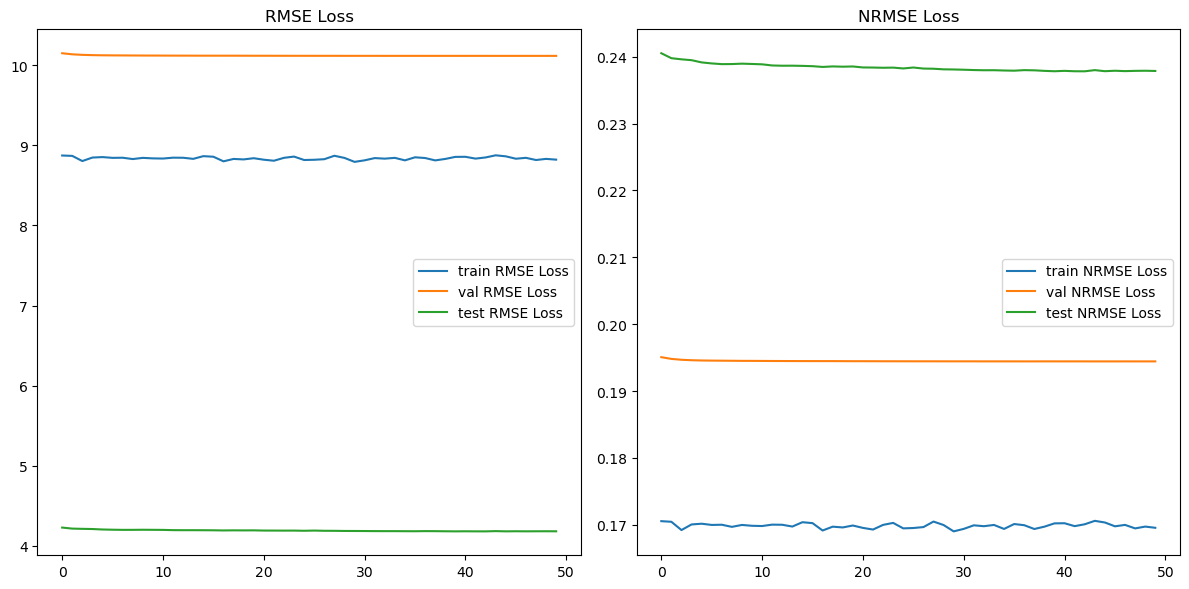

In [17]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
# train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list
axs[0].plot(train_RMSELoss_list, label='train RMSE Loss')
axs[0].plot(val_RMSELoss_list, label='val RMSE Loss')
axs[0].plot(test_RMSELoss_list, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].plot(train_NRMSELoss_list, label='train NRMSE Loss')
axs[1].plot(val_NRMSELoss_list, label='val NRMSE Loss')
axs[1].plot(test_NRMSELoss_list, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
# plt.savefig('CAE_train_loss.png')  # 你可以更改文件名或格式
plt.savefig(f'/home/wl4023/github_repos/IRP/predict result/Latent space {latent_space}/PCA_LSTM_train_loss.png')
plt.show()

In [18]:
model = LSTM_seq2seq(latent_space, 100)
state_dict = torch.load(f'/home/wl4023/github_repos/IRP/predict result/Latent space {latent_space}/PCA_LSTM.pth')
model.load_state_dict(state_dict)

criterion = RMSELoss()
metric = NRMSE(dataset_1)

In [19]:
test_RMSELoss_list = []
test_NRMSELoss_list = []

recon_predict_list = []

with torch.no_grad():
    test_loss = 0
    test_metric = 0
    for x, y, _, original_y in test_loader:
        input = x
        label = y
        predict = model(input, 5)

        recon_predict=[]
        for i in range(len(x)):
            temp = preprocessor.inverse_transform(pca.inverse_transform(predict[i].cpu().detach().numpy()))
            recon_predict.append(torch.tensor(temp, dtype=torch.float32))

        recon_predict = torch.stack(recon_predict, dim=0)
        recon_predict_list.append(recon_predict)

        test_RMSELoss_list.append(criterion(original_y, recon_predict))
        test_NRMSELoss_list.append(metric(original_y, recon_predict))

recon_predict_list = torch.cat(recon_predict_list)
test_rmse = np.array(test_RMSELoss_list)
test_nrmse = np.array(test_NRMSELoss_list)

test_loss = test_rmse.mean()
test_metric = test_nrmse.mean()

print(f'Ave test loss: {test_loss}, Ave test metric: {test_metric}')

Ave test loss: 4.185253620147705, Ave test metric: 0.23800455033779144


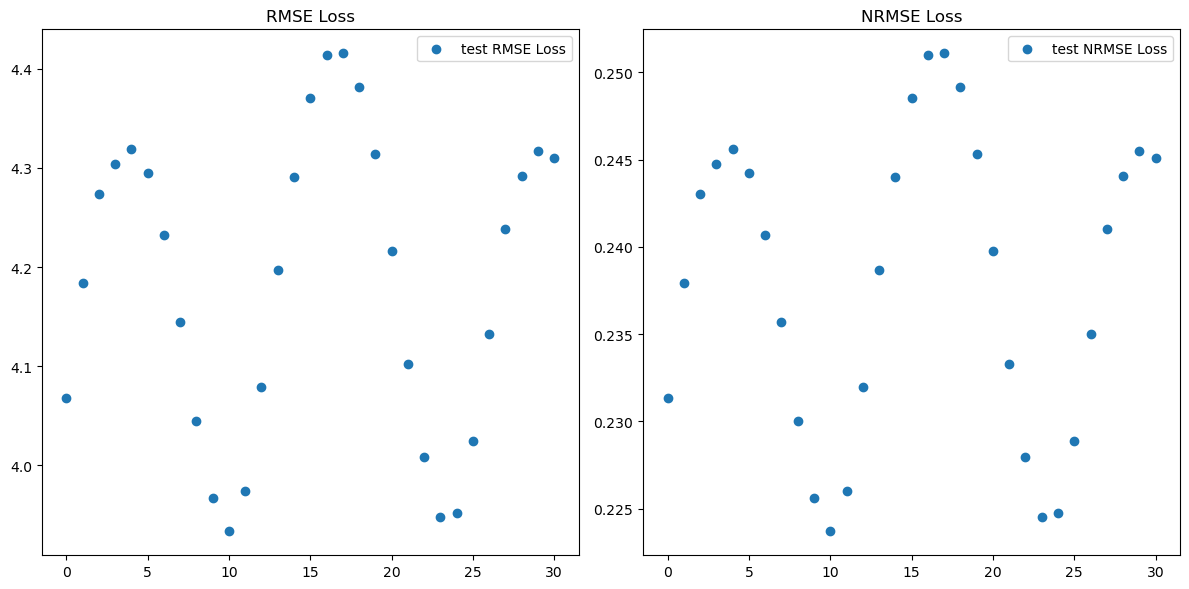

In [20]:
x = np.arange(0, len(test_loader))


# 保存数组到 .npy 文件
# np.save('test_rmse.npy', test_rmse)
# np.save('test_nrmse.npy', test_nrmse)

fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(x, test_rmse, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].scatter(x, test_nrmse, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠

# plt.savefig('CAE_test_loss.png')  # 你可以更改文件名或格式
plt.savefig(f'/home/wl4023/github_repos/IRP/predict result/Latent space {latent_space}/PCA_LSTM_test_loss.png')

plt.show()

In [21]:
def draw_pic(x, y, predict, coords):
    fig, axs = plt.subplots(3, 5, figsize=(30, 18))
    for i in range(axs.shape[-1]):
        axs[0][i].scatter(coords[:,0],coords[:,1],s = 5, c=x[i, :], cmap='bwr')
        axs[0][i].set_title(f'Origin Input {i+1}')

    for i in range(axs.shape[-1]):
        axs[1][i].scatter(coords[:,0],coords[:,1],s = 5, c=y[i, :], cmap='bwr')
        axs[1][i].set_title(f'Real Output {i+1}')

    for i in range(axs.shape[-1]):
        axs[2][i].scatter(coords[:,0],coords[:,1],s = 5, c=predict[i, :], cmap='bwr')
        axs[2][i].set_title(f'Real Output {i+1}')

    plt.savefig(f'/home/wl4023/github_repos/IRP/predict result/Latent space {latent_space}/PCA_LSTM_output.png')
    plt.show()
    plt.close()

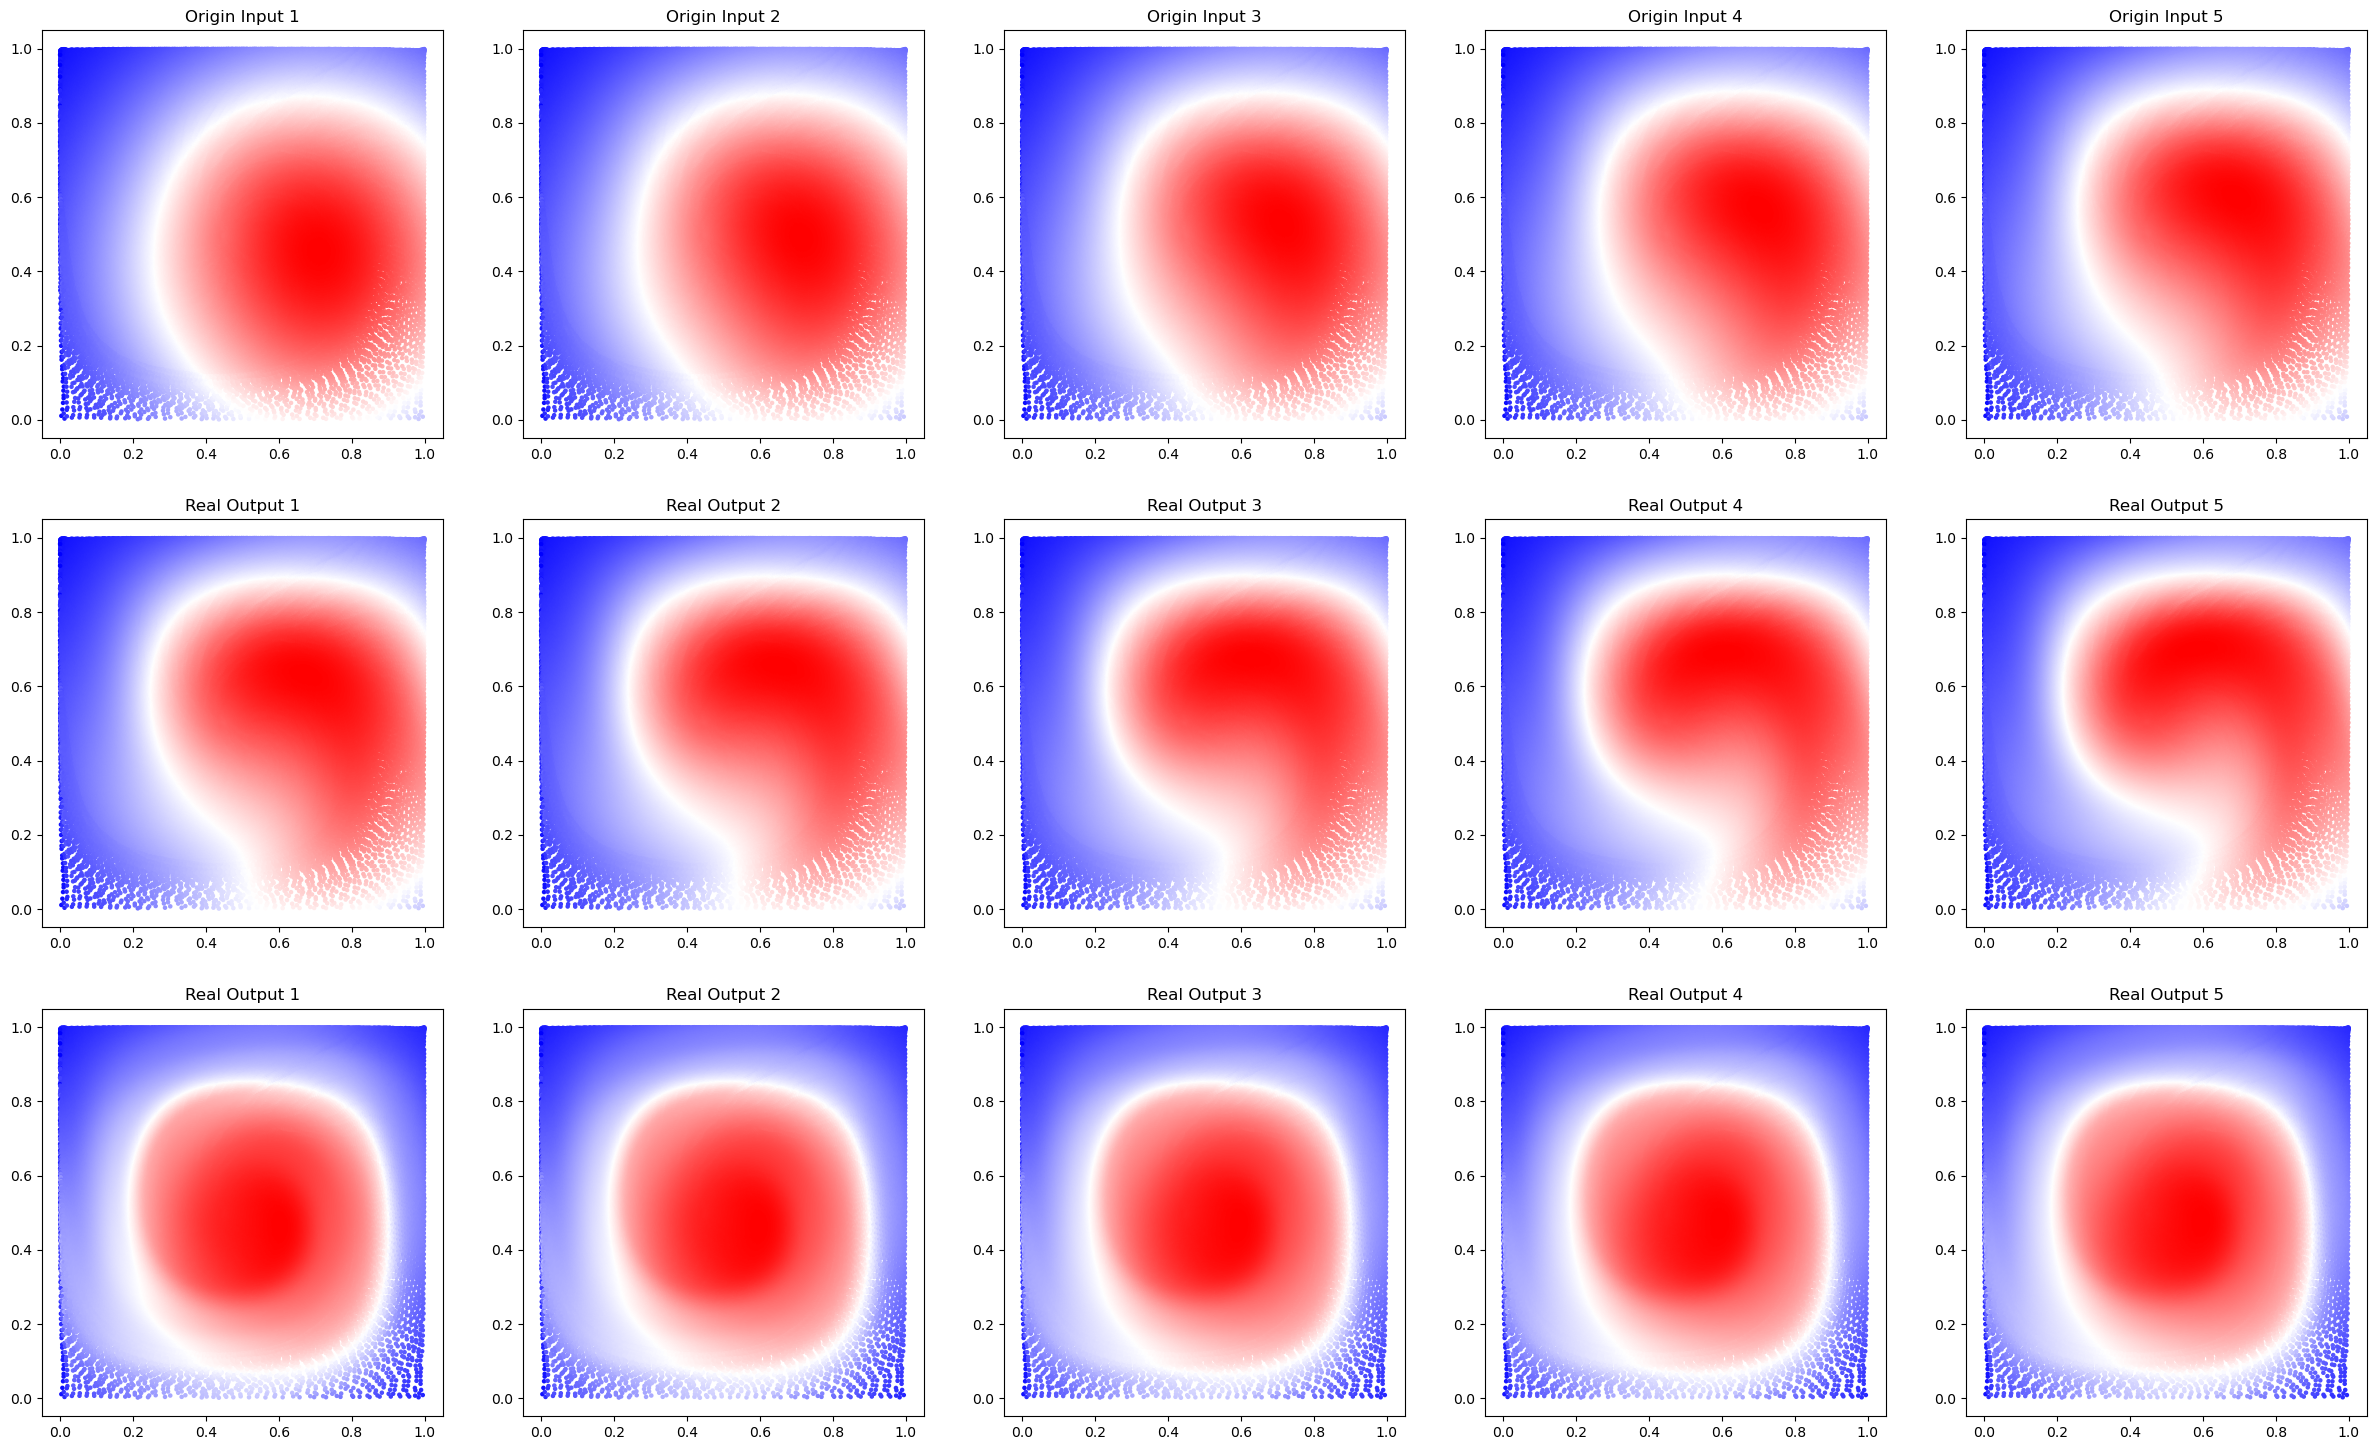

In [22]:
xyfile = "/home/wl4023/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
coords = np.load(xyfile)

_, _, x, y = test_data[0]
predict = recon_predict_list[0]
draw_pic(x, y, predict, coords)